# Выпускной проект: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

* Шаг 1. Загрузка данных

Загрузите данные и выполните их первичный осмотр.


* Шаг 2. Исследовательский анализ и предобработка данных

Выполните исследовательский анализ каждого датафрейма и при необходимости выполните предобработку. Сделайте выводы об имеющихся признаках: понадобятся ли они для обучения моделей.


* Шаг 3. Объединение данных

Объедините выбранные вами признаки в один датафрейм по ключу.


* Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Выполните исследовательский анализ объединённого датафрейма, визуализируйте распределения признаков и при необходимости выполните предобработку. Проведите корреляционный анализ. Напоминаем, что вы можете использовать не только имеющиеся признаки, но и генерировать новые.


* Шаг 5. Подготовка данных

Выполните подготовку данных для обучения модели. Разделите данные на две выборки, при масштабировании и кодировании учитывайте особенности данных и моделей.


* Шаг 6. Обучение моделей машинного обучения

Обучите как минимум две модели. Хотя бы для одной из них подберите как минимум два гиперпараметра.


* Шаг 7. Выбор лучшей модели

Выберите лучшую модель и проверьте её качество на тестовой выборке.


* Шаг 8. Общий вывод и рекомендации заказчику

Сделайте общий вывод о проделанной работе: опишите основные этапы работы, полученные результаты и дайте рекомендации для бизнеса.

## Загрузка данных

Сначала импортируем все необходимые библиотеки

In [1]:
!pip install phik

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from matplotlib import pyplot as plt 
import phik
import seaborn as sns
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind



# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score


# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import  SelectKBest, f_classif

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


#Фиксируем константу для рандомизации
RANDOM_STATE = 80724

In [3]:
contract_data = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal_data = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet_data = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone_data = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [4]:
contract_data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [5]:
###contract_data.query('BeginDate < "2020-01-01"')

In [6]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
personal_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [12]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Данные загружены, есть вопрос по разному количеству записей - возможно кто-то из пользователей заключал договор несколько раз, либо есть договора, которые ещё не попали в списки, например, были открыты в 2020 году, но вероятнее всего, люди не ползьуются услугами интернета, а только улсугами телефонной связи. Далее стоит это проверить. Пропусков в данных нет. В некоторых фреймах стоит проверить наличие дубликатов и тип данных привести у необходимому формату, например, к дате. Далее этим займёмся

## Исследовательский анализ и предобработка данных

Сначала выполним предобработку данных, а уже после посмотрим на распределение признаков (глубокий анализ свзаимокорреляцией посмотрим позже, после объединения данных в один фрейм)

Сначада порботаем с фреймом contract_data.

* Необходимо привести все колонку BeginDate к типу datetime
* Привести колонку TotalCharges к типу float
* Проверить наличие дубликатов
* Можно посомтреть с какого периода взяты данные

In [13]:
contract_data['BeginDate'] = contract_data['BeginDate'].astype('datetime64[ns]')

При обработке столбца TotalCharges возникла ошибка пустой строки, исправим это

In [14]:
contract_data.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [15]:
def fill_it(row):
    if row['TotalCharges'] == ' ':
        return row['MonthlyCharges']
    else:
        return row['TotalCharges']

In [16]:
contract_data['TotalCharges'] = contract_data.apply(fill_it,axis=1)

In [17]:
#contract_data[contract_data['TotalCharges'] == ' ']['TotalCharges'] = contract_data['MonthlyCharges']

In [18]:
contract_data.iloc[488]

customerID                         4472-LVYGI
BeginDate                 2020-02-01 00:00:00
EndDate                                    No
Type                                 Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                            52.55
Name: 488, dtype: object

In [19]:
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'])

In [20]:
print(contract_data['customerID'].duplicated().sum())
print(contract_data.duplicated().sum())

0
0


Дубликатов нет

In [21]:
print(min(contract_data['BeginDate']))
print(max(contract_data['BeginDate']))

2013-10-01 00:00:00
2020-02-01 00:00:00


Данные собраны за период 7 с лишним лет

In [22]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Посмотрим сколько пользователей было зарегистрировано в 2020 году

In [23]:
len(contract_data.query('BeginDate >= "2020-01-01"'))

244

Все что нужно сделано, со столбцом EndDate будем работать отдельно уже в объединённом фрейми, когда начнём генерить новые признаки

Посмотрим на распределение признаков для данного фрейма

In [24]:
num_cols = ['MonthlyCharges','TotalCharges','BeginDate']
cat_cols = ['Type','PaperlessBilling','PaymentMethod']

In [25]:
pd.Series(contract_data['EndDate'] != 'No').sum()

1101

Более 1 тыс человек рано или поздно прервали договор, то есть их можно классифицировать как ушедших. 

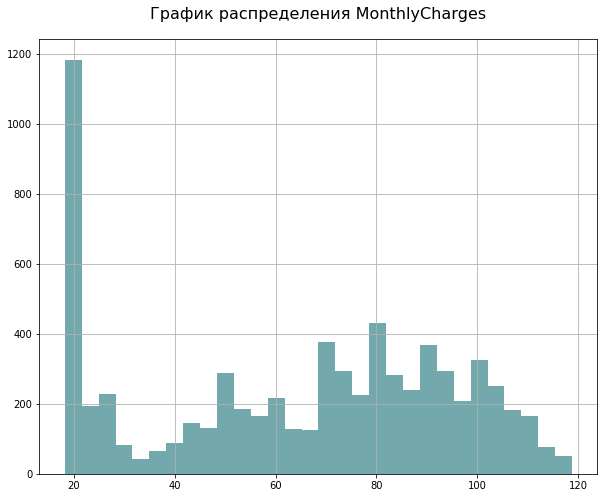

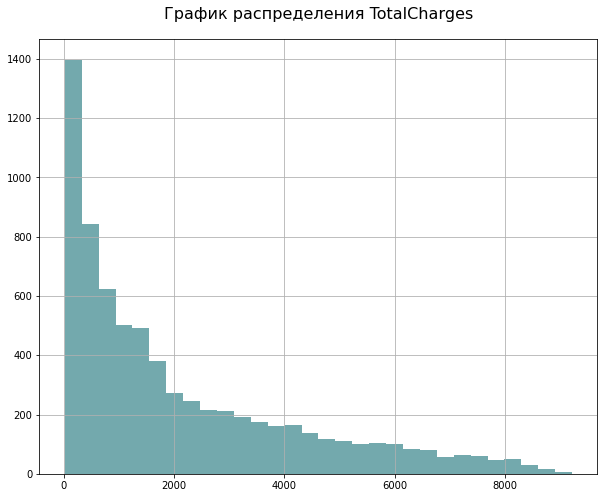

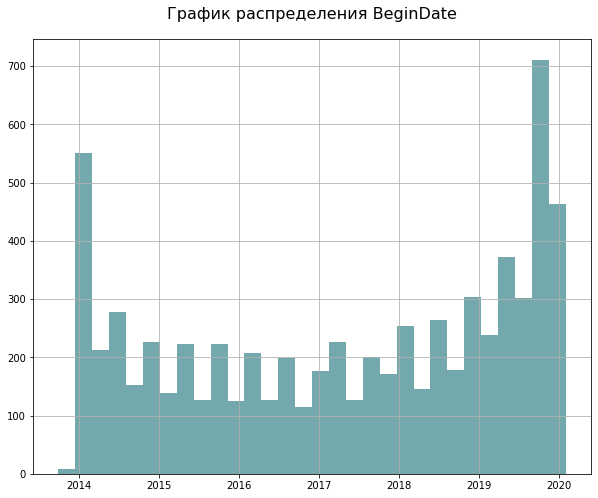

In [26]:
for col in num_cols:
    contract_data[col].hist(bins=30,figsize=(10,8),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()

По распределениям есть несколько вопросов - очень большой пик MonthlyCharges у нуля - возможно люди так и не оплатили ни один месяц, подписали договор, и не стали двигаться дальше, то же и у TotalCgharges - возможно, это одни и те же люди. Думаю, чтт эти данные лучше убрать из выборки. По распределению BeginDate динамика неплохая - количество договоров росло с 2017 по 2020 года

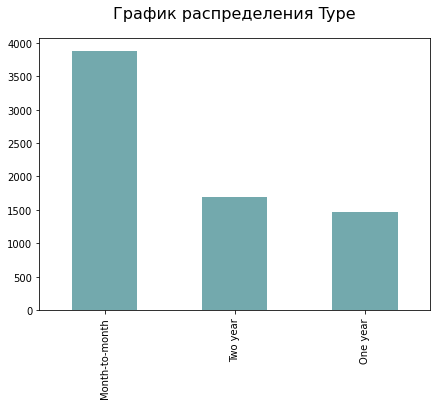

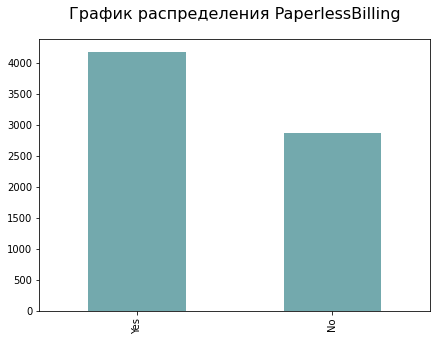

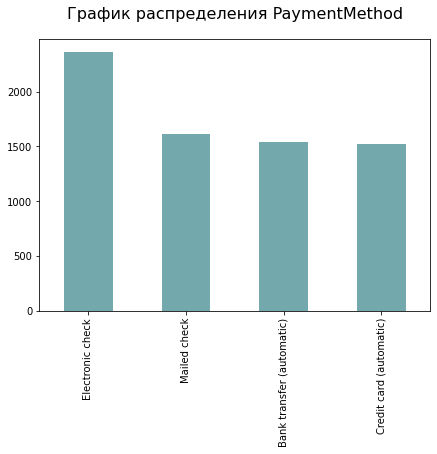

In [27]:
for col in cat_cols:
    contract_data[col].value_counts().plot(kind='bar',figsize=(7,5),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()

По категориальным признакам никаких вопросов нет - чаще люди платят за связь и интернет помесячно, у большинства есть электронный расчётны лист и платят электронным чеком

Перейдём к таблице PersonalData

In [28]:
personal_data.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
5249,5115-GZDEL,Male,0,No,Yes
4713,7544-ZVIKX,Male,0,Yes,Yes
1701,6097-EQISJ,Female,0,Yes,Yes
4759,8740-CRYFY,Male,0,No,No
2291,7488-MXJIV,Female,0,No,No


In [29]:
cat_cols = personal_data.columns.drop('customerID')

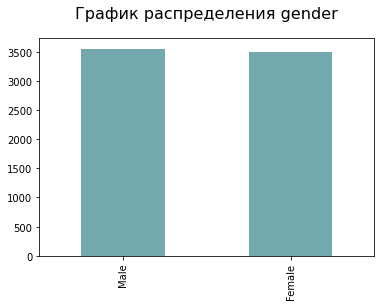

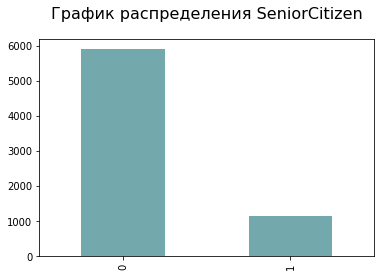

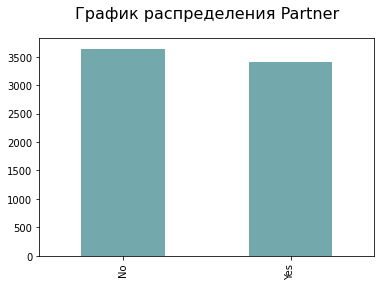

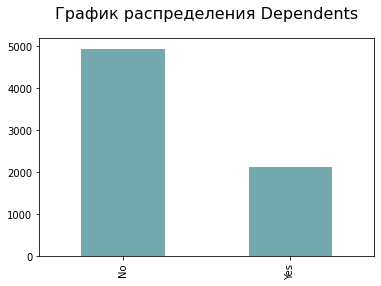

In [30]:
for col in cat_cols:
    personal_data[col].value_counts().plot(kind='bar',figsize=(6,4),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()

На основе распределения признаков можно сказать, что мужчины и женщины практически одинаково участвуют в подписании договоров на улсуги связи. Большинство пользователей не являются пенсионерами, по наличию\отсутсвтию партнера пользователи распрееделны одинаково, у большинства пользователей нет иждивенцев

Сделаем небольшую предобработку и заменим в столбцах Partner и Dependents на числовую мигалку

In [31]:
for col in ['Partner','Dependents']:
    personal_data[col] =  personal_data[col].apply(lambda x: 1 if x =='Yes' else 0)

In [32]:
internet_data.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4658,8019-ENHXU,Fiber optic,No,Yes,Yes,Yes,No,Yes
45,9420-LOJKX,Fiber optic,Yes,Yes,No,No,Yes,Yes
2544,9620-ENEJV,Fiber optic,No,No,No,No,No,No
4774,0623-EJQEG,Fiber optic,Yes,No,No,Yes,No,Yes
5464,8468-FZTOE,DSL,Yes,Yes,Yes,Yes,No,Yes


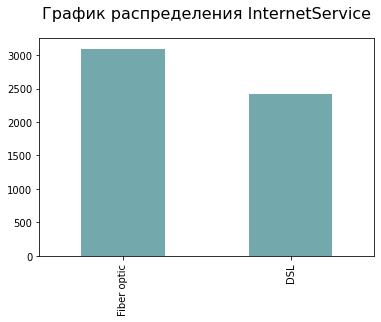

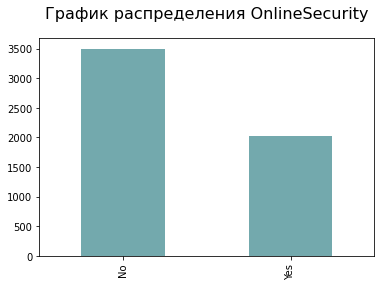

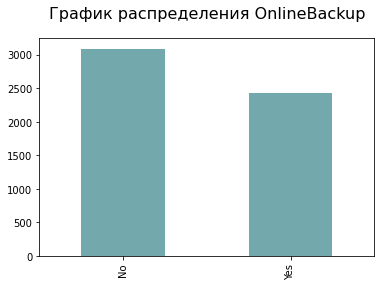

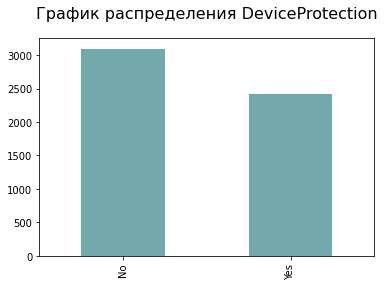

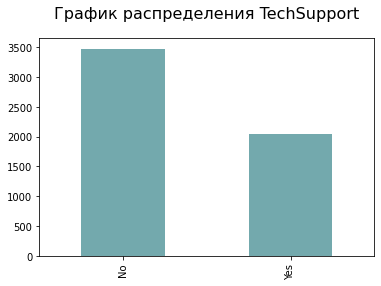

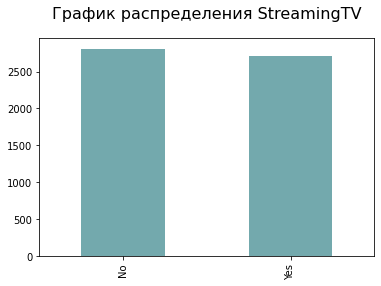

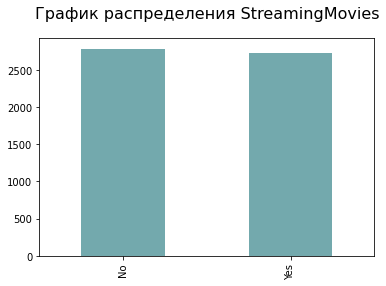

In [33]:
for col in internet_data.columns.drop('customerID'):
    internet_data[col].value_counts().plot(kind='bar',figsize=(6,4),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()

In [34]:
#for col in internet_data.columns.drop(['customerID','InternetService']):
#    internet_data[col] =  internet_data[col].apply(lambda x: 1 if x =='Yes' else 0)

In [35]:
phone_data.sample(5)

,customerID,MultipleLines
3939,5792-JALQC,Yes
5369,9500-WBGRP,No
4153,0599-XNYDO,No
5493,4003-FUSHP,No
2103,6670-MFRPK,Yes


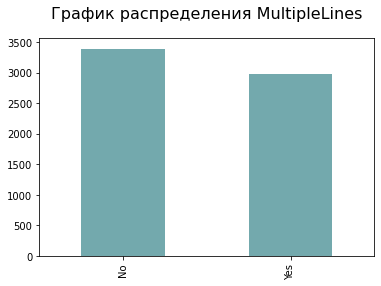

In [36]:
phone_data['MultipleLines'].value_counts().plot(kind='bar',figsize=(6,4),color='#73A9AD')
plt.title(f'График распределения MultipleLines',size=16,pad=20)
plt.show()

In [37]:
#phone_data['MultipleLines'] = phone_data['MultipleLines'].apply(lambda x: 1 if x =='Yes' else 0)

В целом предобработка и начальный анализ признаков завершены. 
Я привёл данные в первом датафрейме к необходимому формату, а такде посмотрел на распределение признаков по всем фреймам. 1/7 всех пользователей рано или поздно расторгла договор. Двигаемся дальше

## Объединение данных

Объединим все данные по ключу CustomerID, будем использовать способ outer, чтобы проследить особенность данных

In [38]:
full_data = contract_data.merge(personal_data,on='customerID',how='outer')

In [39]:
full_data = full_data.merge(internet_data,on='customerID',how='outer')

In [40]:
full_data = full_data.merge(phone_data,on='customerID',how='outer')

In [41]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Всё верно, в первых двух фреймах собраны полные данные о всех пользователях, в оставшихся - дополнительные услуги (либо телефон, либо интернет, либо и то, и другое)

In [42]:
full_data.sample(7)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1134,2208-NQBCT,2017-12-01,No,Month-to-month,No,Electronic check,81.95,2130.70,Female,0,1,1,Fiber optic,Yes,Yes,No,No,No,No,No
5801,8695-ARGXZ,2017-04-01,No,Month-to-month,Yes,Electronic check,75.55,2568.70,Male,1,1,0,Fiber optic,No,No,No,No,No,No,Yes
2321,9776-OJUZI,2014-09-01,No,Month-to-month,Yes,Bank transfer (automatic),95.45,6700.59,Female,1,0,0,Fiber optic,No,Yes,Yes,No,Yes,No,Yes
4490,0442-ZXKVS,2015-08-01,No,One year,Yes,Bank transfer (automatic),115.60,6242.40,Female,1,1,0,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1877,7873-CVMAW,2014-02-01,No,Two year,No,Credit card (automatic),88.55,6375.60,Male,0,0,0,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6992,0218-QNVAS,2014-03-01,No,One year,No,Bank transfer (automatic),100.55,7638.78,Male,0,1,1,Fiber optic,No,Yes,No,No,Yes,Yes,Yes
2258,9150-HEPMB,2015-06-01,No,One year,No,Mailed check,52.70,3010.22,Male,0,0,0,DSL,Yes,No,Yes,No,No,No,No


В данном шаге я объединил все данные в один фрейм. Объединение я производил по ключу CustomerID, оказалось,  что в первом и втором фреймах была собрана информация о всех пользователях, а в третьем и четвертом об интернет услугах и услугах телефонии. После объединения у нас появились пропуски в данных, которые далее мы обработаем и заполним

## Исследовательский анализ и предобработка данных объединённого датафрейма

Объединение данных дало новые пропуски в данных, но их можно заплонить по логике на 'No' - услуга не оказывается, поэтому пользователя не было в другом датафрейме. К тому же замена пропусков производится только в строковых столбцах

In [43]:
full_data = full_data.fillna('No')

In [44]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Для начала создадим целевой признак leave_target, который будет производным от признака EndDate - если в EndDate стоит значение No, то присваиваем записи 0, иначе присваиваем 1 - человек расторг договор

In [45]:
#full_data['leave_target'] = full_data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
full_data['leave_target'] = (full_data['EndDate'] != 'No').astype(int)
full_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,leave_target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,0,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,0,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,0,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,0,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,0,Fiber optic,No,No,No,No,No,No,No,0


In [46]:
#full_data['PaperlessBilling'] = full_data['PaperlessBilling'].apply(lambda x: 0 if x == 'No' else 1)

Также создидим доп признак - количество месяцев между началом и концом договора, если договор дейсвтителен берем дату сбора данных (1 февраля 2020 года.) Далее удалим колонки BeginDate и EndDate, чтобы у нас не произошло утечки целевого признака, и уже после этого можно проводить исследовательнский и корреляционный анализы

In [47]:
full_data['EndDate'] = full_data['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x).astype('datetime64[ns]')

In [48]:
#full_data['contract_duration'] = (full_data['EndDate'] - full_data['BeginDate'])
#full_data['contract_duration'] = full_data['contract_duration'].apply(lambda x: x.days)
full_data['contract_duration'] = (full_data['EndDate'] - full_data['BeginDate']).dt.days

In [49]:
full_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,leave_target,contract_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


In [50]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerID         7043 non-null   object        
 1   BeginDate          7043 non-null   datetime64[ns]
 2   EndDate            7043 non-null   datetime64[ns]
 3   Type               7043 non-null   object        
 4   PaperlessBilling   7043 non-null   object        
 5   PaymentMethod      7043 non-null   object        
 6   MonthlyCharges     7043 non-null   float64       
 7   TotalCharges       7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   SeniorCitizen      7043 non-null   int64         
 10  Partner            7043 non-null   int64         
 11  Dependents         7043 non-null   int64         
 12  InternetService    7043 non-null   object        
 13  OnlineSecurity     7043 non-null   object        
 14  OnlineBa

Прежде чем переходить к исследованию распределения признаков, посмотрим на матрицу корреляций. Предварительно убрав признак CustomerID

In [51]:
full_data.drop('customerID',axis=1,inplace=True)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'leave_target', 'contract_duration']


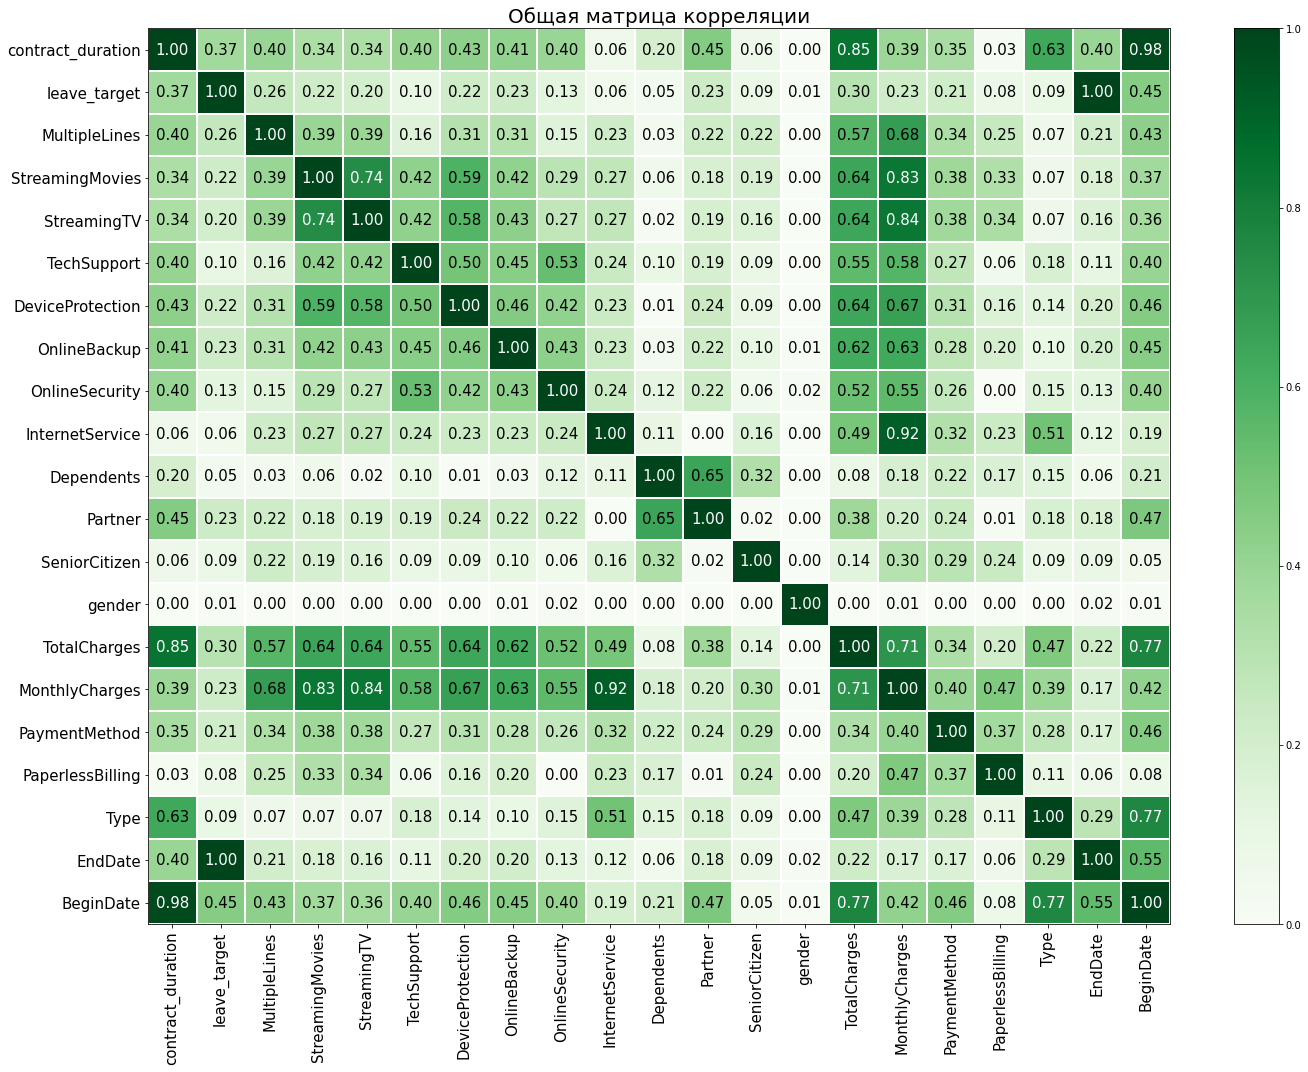

In [52]:
phik_matrix = full_data.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции',size=20)
plt.show()

У нас есть несколько достаточно сильно коррелирующих признаков - ежемесячная оплата и дополнительные виды подключения - мы можем либо убрать мультиколлинеарность путём удаления таких признаков, либо предусмотреть в линейных моделях регуляризацию, а в моделях бустинга и решающих деревьев мультиколлинеарность не страшна, эти алгоритмы умеют с ней справляться. Поэтому оставим на этом этапе всё как есть.

Стоит убрать BeginDate и EndDate с CustomerId, которые сильно коррелируют с целевым и новым признаком,сделаем это после исследовательского анализа

In [53]:
cat_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'MultipleLines', 'leave_target','PaperlessBilling','Type','InternetService']
num_cols = ['MonthlyCharges', 'TotalCharges','contract_duration']

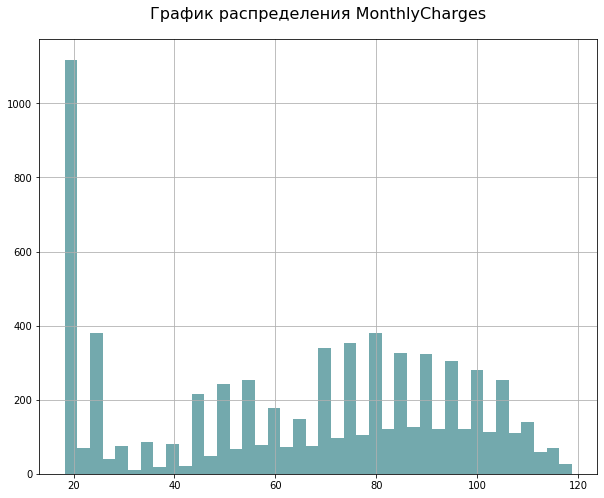

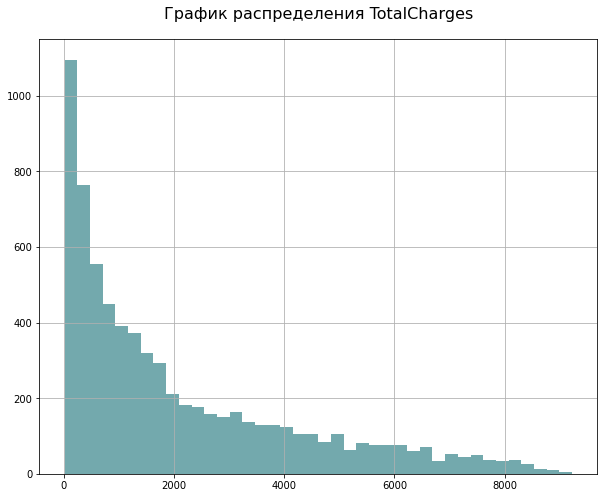

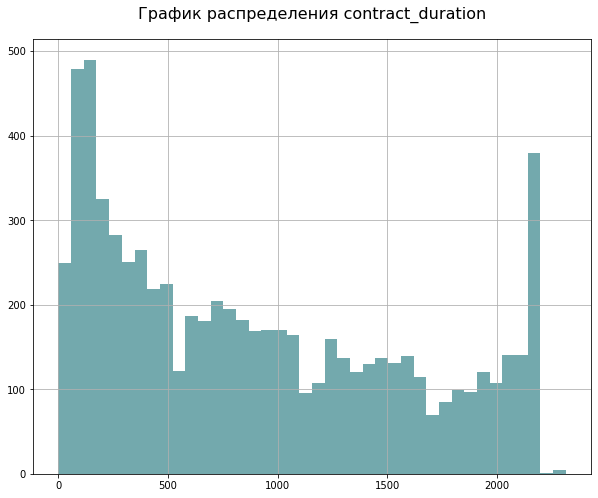

In [54]:
for col in num_cols:
    full_data[col].hist(bins=40,figsize=(10,8),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.show()

Интересно, возможно, этот нулевой хвост и связан с людьми, которые практически не пользовались услугами, или создали договор, но не стали его оплачивать, проверим это

In [55]:
zero_persons = full_data.query('MonthlyCharges < 20 and TotalCharges < 20')
zero_persons.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,leave_target,contract_duration
count,33.000000,33.000000,33.0,33.000000,33.000000,33.0,33.000000
mean,19.487879,19.545758,0.0,0.272727,0.333333,0.0,29.121212
std,0.288864,0.260169,0.0,0.452267,0.478714,0.0,7.511481
min,18.800000,19.050000,0.0,0.000000,0.000000,0.0,0.000000
25%,19.250000,19.400000,0.0,0.000000,0.000000,0.0,31.000000
50%,19.550000,19.550000,0.0,0.000000,0.000000,0.0,31.000000
75%,19.700000,19.750000,0.0,1.000000,1.000000,0.0,31.000000
max,19.950000,19.950000,0.0,1.000000,1.000000,0.0,31.000000


<AxesSubplot:>

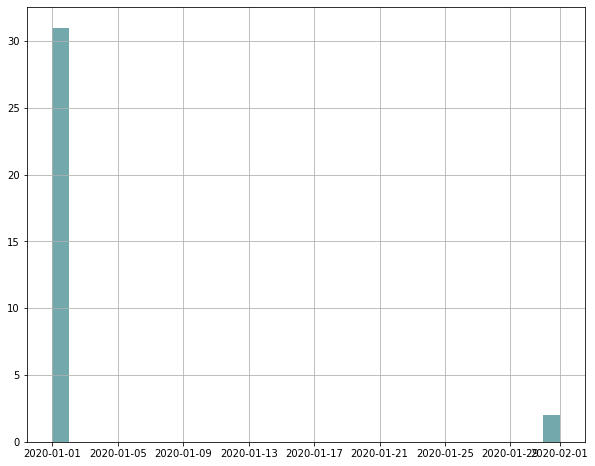

In [56]:
zero_persons['BeginDate'].hist(bins=30,figsize=(10,8),color='#73A9AD')

Стало понятно, что эти пики в начале соответсвуют людям, которые подписали контракт перед сбором данных в 2020 году. Тогда можно оставить данные как есть, и не трогать этих новичков

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> С выводом согласен — это новые клиенты и для них мы также должны предсказывать отток.  
        
</div>

In [57]:
full_data = full_data.drop(['BeginDate','EndDate'],axis=1)

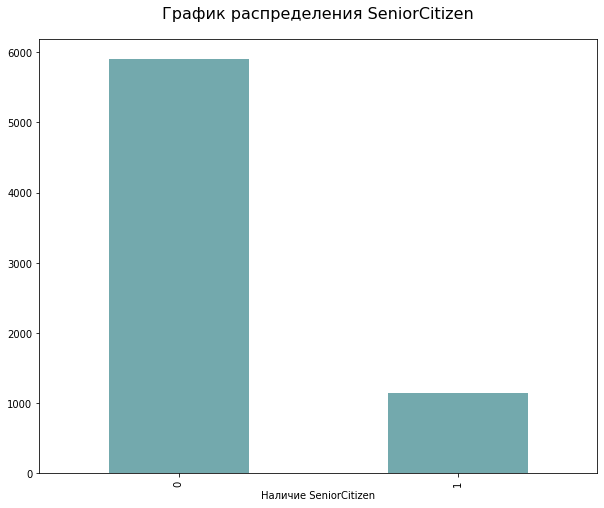

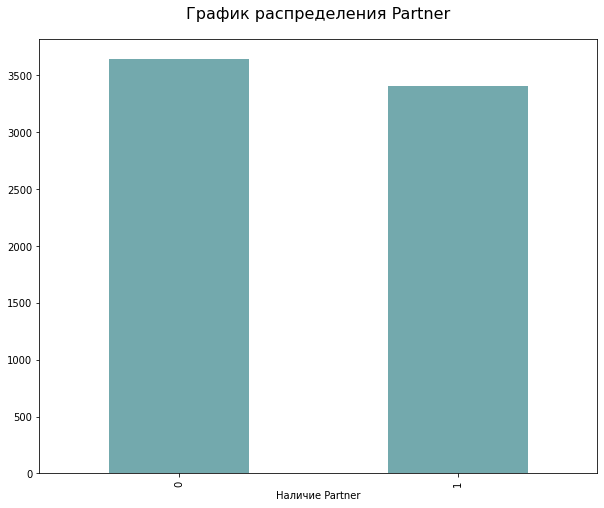

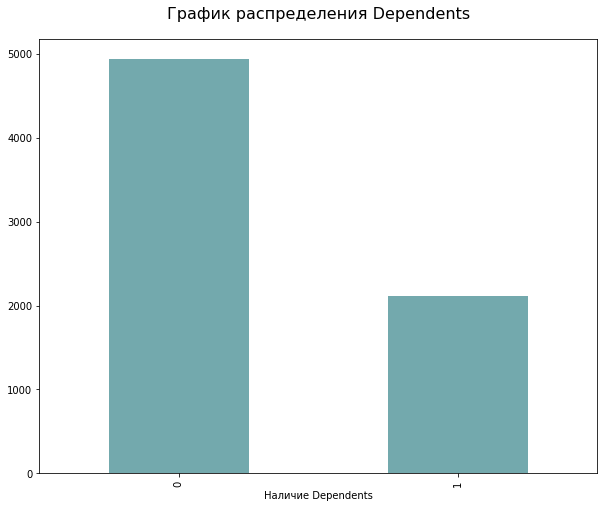

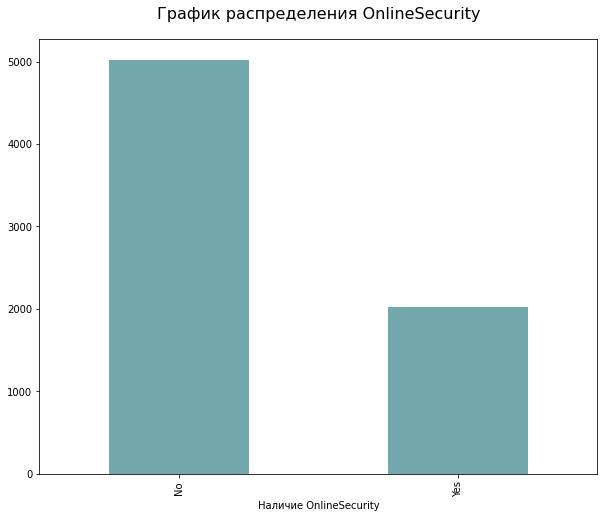

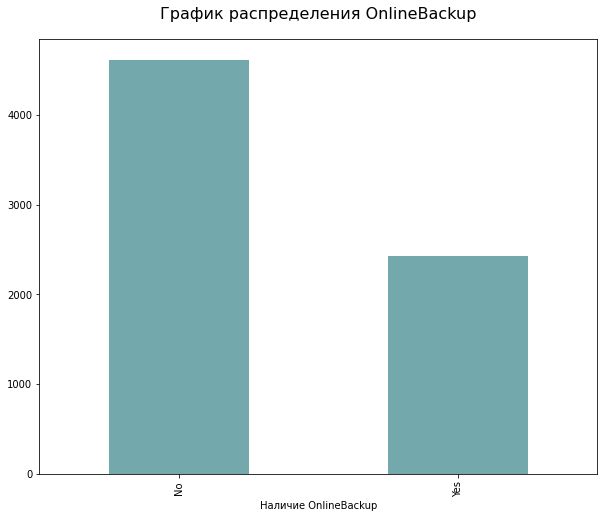

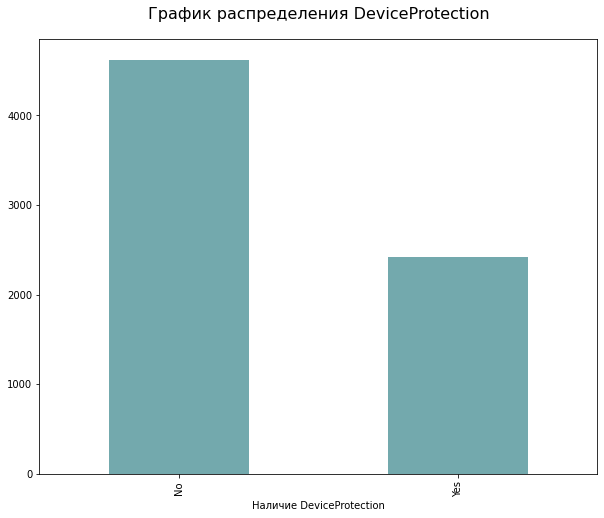

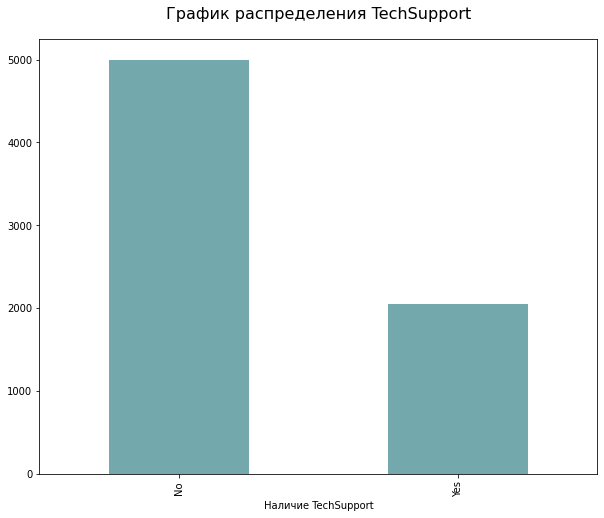

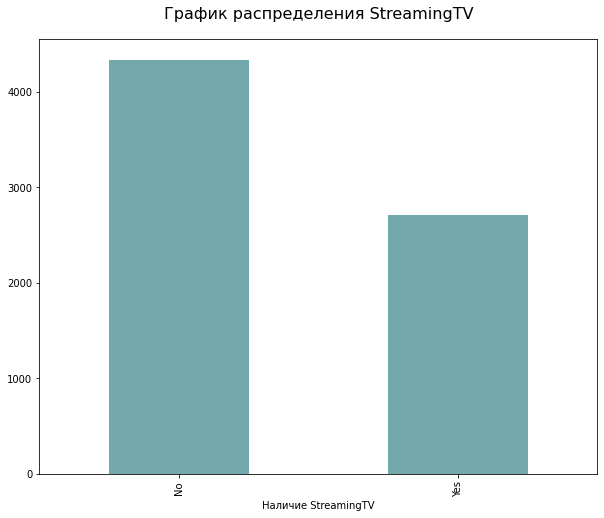

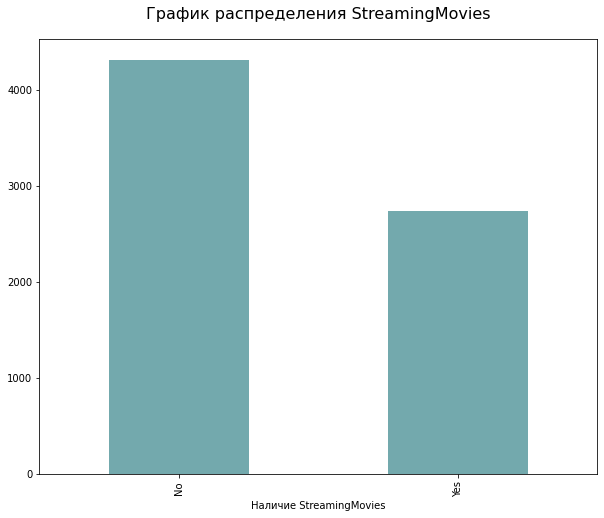

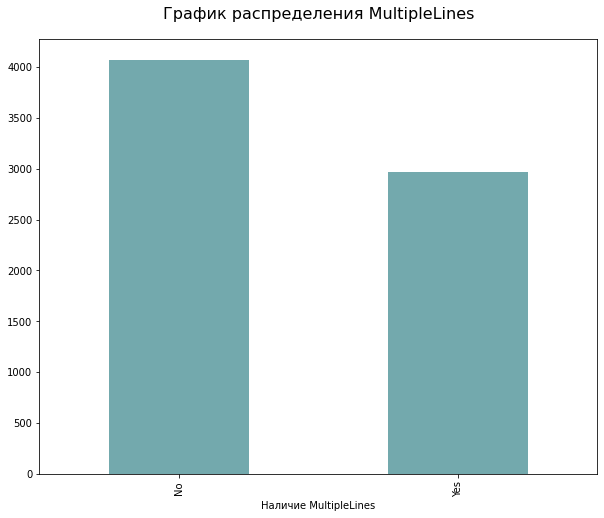

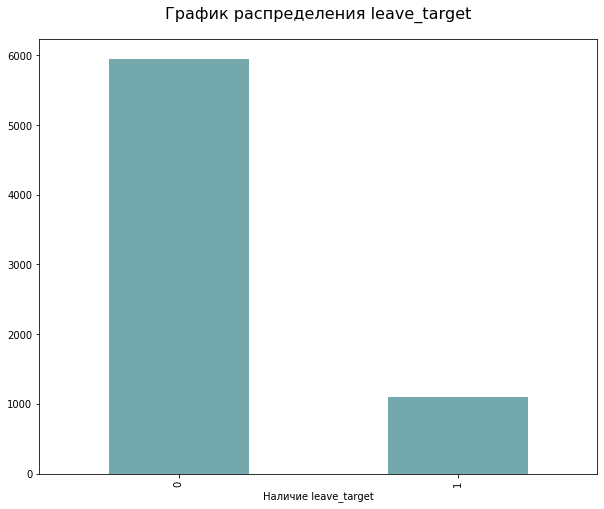

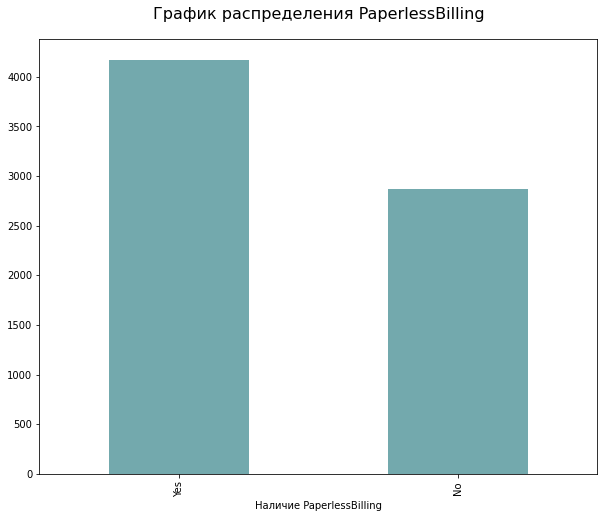

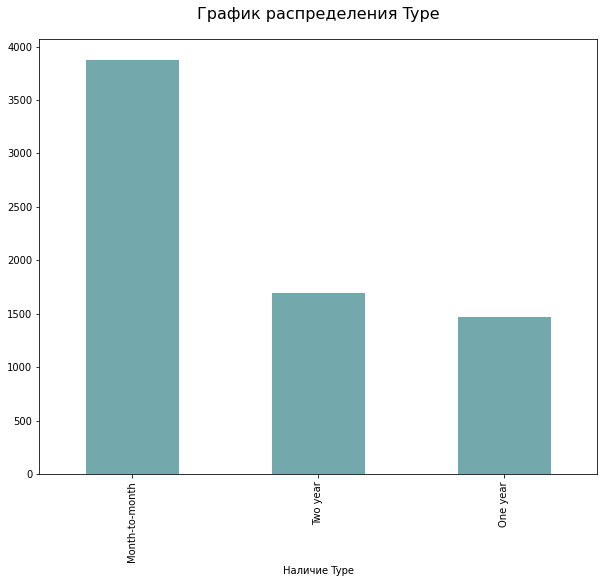

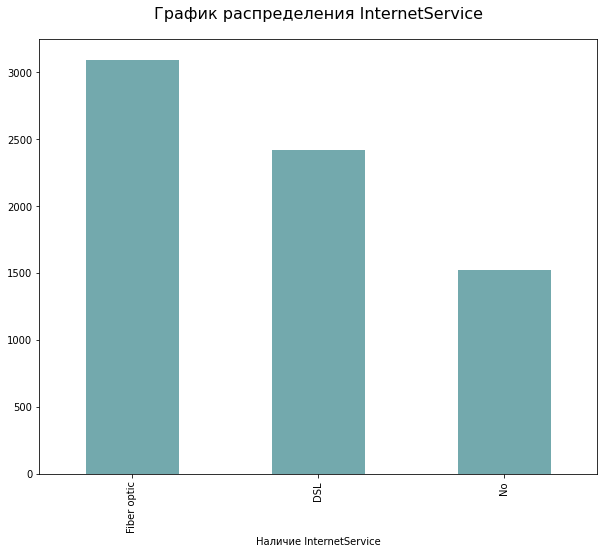

In [58]:
for col in cat_cols:
    full_data[col].value_counts().plot(kind='bar',figsize=(10,8),color='#73A9AD')
    plt.title(f'График распределения {col}',size=16,pad=20)
    plt.xlabel(f'Наличие {col}')
    plt.show()

Можно сказать, что у достаточно большого количества человек есть дополнительные услуги связи и интернета. Еще в последнем распределении есть проблема - 0, после неудачного заполнения всех пропусков на 0, измени это, чтобы дальше не возникало ошибок

In [59]:
full_data['InternetService'] = full_data['InternetService'].apply(lambda x: x if x == 'Fiber optic' or x == 'DSL' else 'No' )

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'leave_target', 'contract_duration']


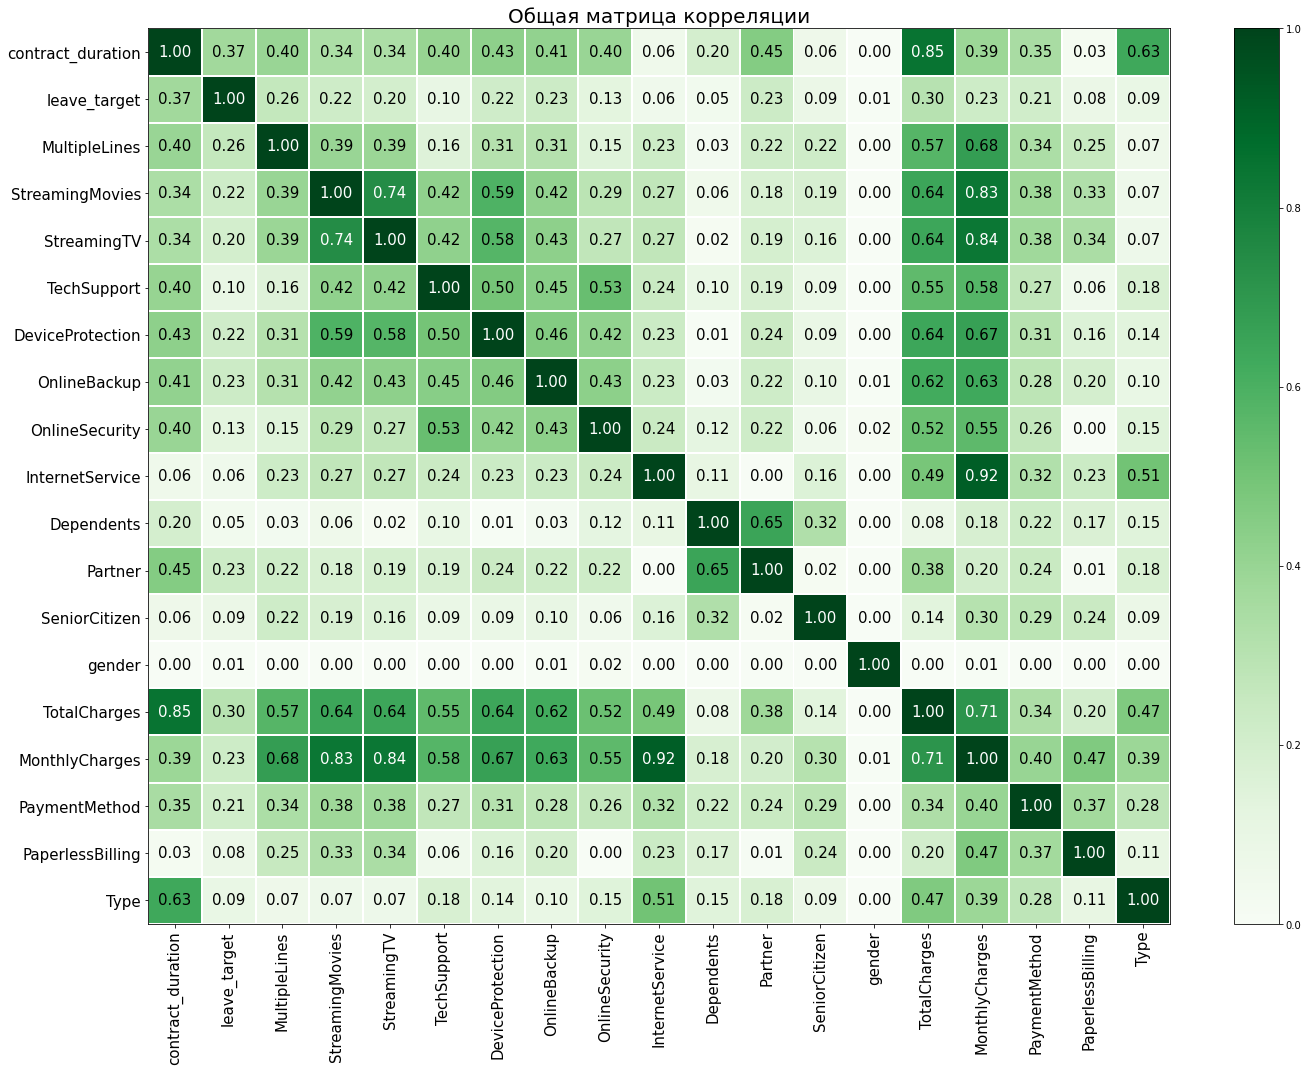

In [60]:
phik_matrix = full_data.phik_matrix()
plot_correlation_matrix(
phik_matrix.values,
y_labels=phik_matrix.index,
x_labels=phik_matrix.columns,
vmin=0,vmax=1,
figsize=(20,15),
fontsize_factor=1.5,
color_map='Greens'
)
plt.title('Общая матрица корреляции',size=20)
plt.show()


Интересно, что у признака пол клиента нет никакой корреляции с какими либо признаками

Корреляционный и исследовательский анализы завершены - после объединения фреймов у нас возникло несколько пропусков, которые мы заменили на ноль - отсутствие услуги. Далее мы создали целевой признак на основе признака EndDate, также был создан дополнительный признак - длительность договора, на основе признаков BeginDate и EndDate. После эти признаки были удалены, чтобы у нас не было утечки целевого признака. При проведени корреляционного анализа была замечена корреляция (сильная) между несколькими признакми, я решил оставить все как есть и учесть этот момент уже при обучении моделей. Также был замечен небольшой пик в самом нечале числовых признаков - это было связано с пользователями подписавшими договор перед самым сбором данных

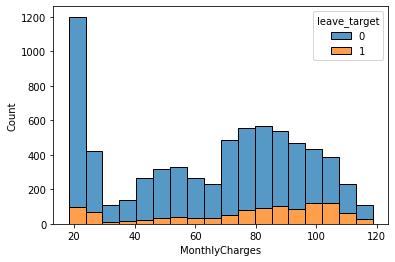

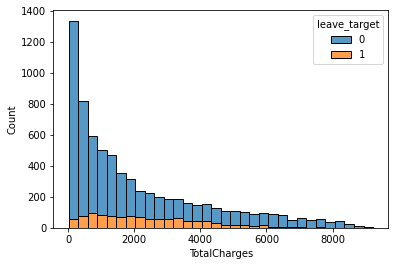

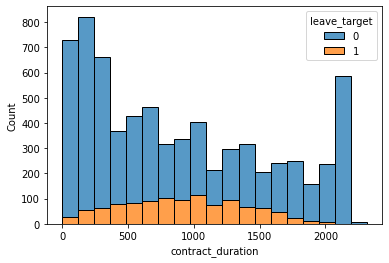

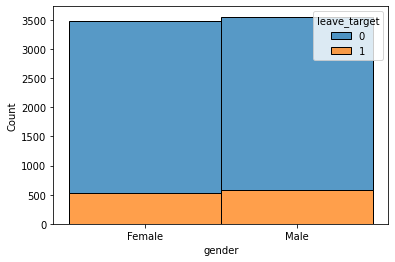

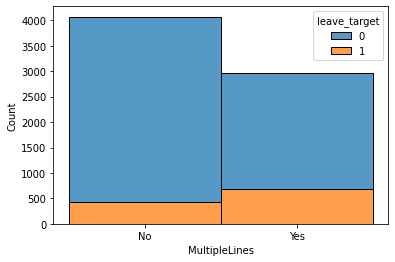

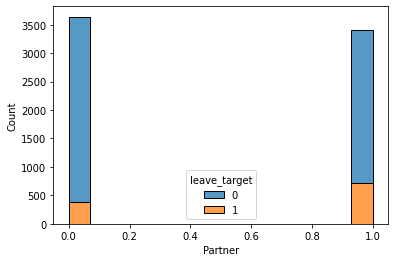

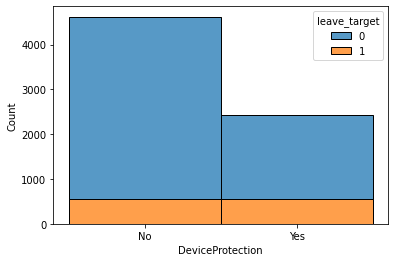

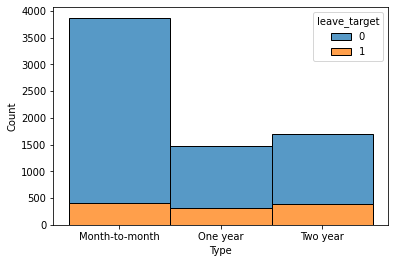

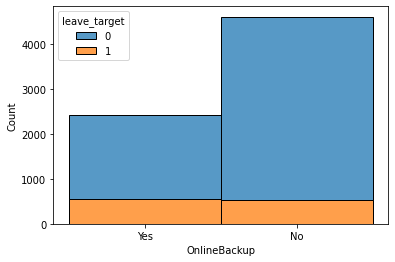

In [61]:
for col in ['MonthlyCharges','TotalCharges','contract_duration','gender',\
            'MultipleLines','Partner','DeviceProtection','Type','OnlineBackup']:
    sns.histplot(full_data, x=col, hue='leave_target', multiple="stack")
    plt.show()

По анализу оставшихся и ушедших людей есть интересные наблюдения - при увеличении ежемесячной оплаты вероятность разрыва договора увеличивается, точно также как и при подключении доп сервисов (DeviceProtection, OnlineBackup и MultipleLines) , думаю, постепенно в них исчезанет надобность. Также наличие партнёра приводит к увеличению риска потери клиента. Также короткосрочные договора с клиентами менее рискованные 

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Хороший анализ данных — все понятно и подробно! Здорово, что исследовал влияние признаков на отток клиентов 👍
    
***
    
Еще нужно помнить, что влияние различных факторов на целевую переменную, это гипотеза, и нужно использовать методы проверки гипотез. Но это уже отдельная работа =)    
   
</div>

## Подготовка данных

Подели выборку на тестовую и тренировочну, далее создидм пайплайн, и закодируем все необходимые признаки, после чего можно перейти к гиперпараметрам и обучению модели кросс валидацией. Не забудем про стратификацию

In [62]:
X_train, X_test, y_train, y_test = train_test_split(full_data.drop('leave_target',axis=1)\
                                                    ,full_data['leave_target'],test_size=0.25,\
                                                    random_state=RANDOM_STATE,stratify=full_data['leave_target'])

In [63]:
X_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contract_duration
4948,Month-to-month,No,Credit card (automatic),55.50,230.88,Female,0,0,0,DSL,No,No,No,No,Yes,No,No,123
4553,Two year,Yes,Bank transfer (automatic),115.80,8504.35,Male,0,1,0,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2191
6545,Month-to-month,Yes,Electronic check,74.65,746.50,Female,0,0,0,DSL,Yes,Yes,No,No,Yes,Yes,No,306
3581,Two year,No,Credit card (automatic),74.50,4787.37,Male,0,1,1,DSL,Yes,Yes,Yes,Yes,Yes,No,No,1918
6381,Month-to-month,No,Mailed check,19.55,20.53,Male,0,0,1,No,No,No,No,No,No,No,No,31


In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 4948 to 1168
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               5282 non-null   object 
 1   PaperlessBilling   5282 non-null   object 
 2   PaymentMethod      5282 non-null   object 
 3   MonthlyCharges     5282 non-null   float64
 4   TotalCharges       5282 non-null   float64
 5   gender             5282 non-null   object 
 6   SeniorCitizen      5282 non-null   int64  
 7   Partner            5282 non-null   int64  
 8   Dependents         5282 non-null   int64  
 9   InternetService    5282 non-null   object 
 10  OnlineSecurity     5282 non-null   object 
 11  OnlineBackup       5282 non-null   object 
 12  DeviceProtection   5282 non-null   object 
 13  TechSupport        5282 non-null   object 
 14  StreamingTV        5282 non-null   object 
 15  StreamingMovies    5282 non-null   object 
 16  MultipleLines      52

В данном случае мы можем воспользоваться кодировщиком OHE для категориальных признаков PaymentMethod, gender, InternetService итп, а также нормализатором для числовых признаков MonthlyCharges, contract_duration и TotalCharges
 

Начнём создавать пайплайн

In [65]:
ohe_columns = X_train.columns.drop(['MonthlyCharges','TotalCharges','contract_duration','SeniorCitizen'])
num_columns = ['MonthlyCharges','TotalCharges','contract_duration']

In [66]:
#Кодировщик номинальных категориальных признаков
ohe_pipe = Pipeline(
[
#     ('simpleImputer_ohe',SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first',sparse=False))
    
])

#Кодировщик ранговых категориальных признаков
# ord_pipe = Pipeline(
# [
#     ('simpleImputer_before_ord',SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
#     ('ord',OrdinalEncoder(categories=[
#         ['Month-to-month','One year','Two year']
#     ],handle_unknown='use_encoded_value',unknown_value=np.nan)),
#     ('simpleImputer_after_ord',SimpleImputer(missing_values=np.nan,strategy='most_frequent'))
# ])

#Пайплайн предобработки данных
data_preprocessor = ColumnTransformer([
    ('ohe',ohe_pipe,ohe_columns),
#     ('ord',ord_pipe,ord_columns),
    ('num',StandardScaler(),num_columns)
],
remainder='passthrough')


In [67]:
pipe_final = Pipeline(
[
    ('preprocessor',data_preprocessor),
    ('models',LogisticRegression( random_state=RANDOM_STATE, 
            solver='liblinear',class_weight='balanced'))
])



param_distr_linear = [
    {
    'models' :[LogisticRegression( random_state=RANDOM_STATE, 
            solver='liblinear',class_weight='balanced')],
    'models__penalty':['l1','l2'],
    'models__C':range(1,50,10),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()] 
        
    }]
param_distr_neighbors = [
    {
      
    'models':[KNeighborsClassifier()],
    'models__n_neighbors':range(1,20,5),
    'preprocessor__num':[StandardScaler(),MinMaxScaler(),RobustScaler()]  
    }]
    
    
param_distr_tree = [    {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE,class_weight='balanced')],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }]
    
    
param_distr_cat_boosting =     [{
    'models': [CatBoostClassifier(verbose=100)],
        'models__iterations': [10,20,50],
        'models__learning_rate': [0.25,0.5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }]
    
param_distr_xgb_boosting =     [{
    'models': [XGBClassifier()],
        'models__iterations': [20,50],
        'models__max_depth': range(3,4),
        'models__learning_rate': [0.25,0.5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }
    
]

params = [param_distr_linear,param_distr_neighbors,param_distr_tree,param_distr_cat_boosting,param_distr_xgb_boosting]

На данном этапе я поделил данные на тестовую и обучающую выборки. После создал пайплайн с несколькими кодировщиками для признаков. После я усложнил пайплайн добавив несколько моделей и гиперпараметров 

## Обучение и интерпретация модели

Запустим обучение моделей с попомщью RandomizerCV, целевая метрика - roc-auc

In [68]:
models = []
for param in params:
    randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)

    randomized_search.fit(X_train,y_train)
    print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
    print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
    print(3*'\n',100*'-')
    models.append([randomized_search,randomized_search.best_score_])


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')),
                                                 ('num', RobustScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                   

In [69]:
best_model = max(models,key=lambda x: x[1])[0]

Лучшией моделью оказалась XGBBoosting (модель градиентного бустинга) - с гиперпараметрами 
* learning_rate = 0.5
* max_depth = 3
* iterations = 20
Целевая метрика на тренировочной выборке равна 0.89, что удовлетворяет требованию заказчика

Посмотрим на значимость признаков и интерпретацию модели

In [70]:
feature_importance = best_model.best_estimator_._final_estimator.feature_importances_

In [71]:
preprocessor = best_model.best_estimator_.named_steps['preprocessor']
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns)
feature_names = list(ohe_feature_names) + num_columns + ['SeniorCitizen']

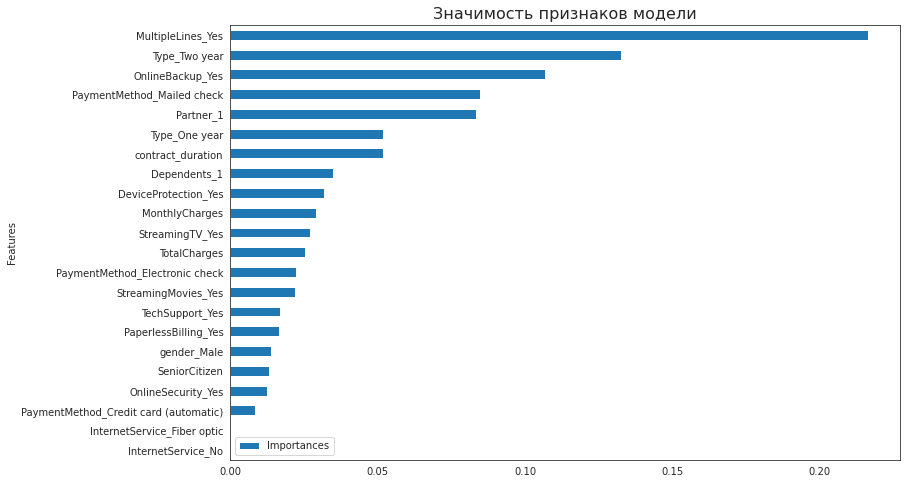

In [72]:
sns.set_style('white')
feature_importances = pd.DataFrame({'Features':feature_names,'Importances':feature_importance})
feature_importances = feature_importances.sort_values(by='Importances',ascending=True)
feature_importances.plot(x='Features',y='Importances',kind='barh',figsize=(12,8))
plt.title('Значимость признаков модели',size=16)
plt.show()

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера v2:</b> По наблюдениям в предыдущих проектах, обычно наиболее значимые признаки — это общие платежи, месячные платежи и длительность контракта, поэтому немного странно, что MultipleLines на первом месте.
    
Советую потом отдельно проверить модели еще раз, как вариант без пайплайна и посмотреть значимость признаков.
    
Есть предположение, что значения признаков и их названия на графике не совпадают, нужно более глубже посмотреть результаты в пайплайне.

</div>

## Выбор лучшей модели

Посмотрим на целевую метрику на тестовой выборке

In [73]:
y_test_pred = best_model.predict_proba(X_test)
print(f'Значение метрики roc_auc финальной модели на тестовой выборке равно {roc_auc_score(y_test,y_test_pred[:,1])}')

Значение метрики roc_auc финальной модели на тестовой выборке равно 0.9222354092744401


## Общий вывод и рекомендации заказчику

Передо мной стояла задача создания модели для оператора связи "ТелеДом", которая могла бы предсказать клиентов, которые собираются перестать пользоваться их услугами с целью их выявления и удержания путём системы лоялности. Для выполнения задачи я вделал следующие шаги

* Выгрузил данные 
* Сделал предварительный анализ и предобработку
* Объединил все файлы с данными в один фрейм
* Выполнил исследловательский и корреляционный анализ
* Добавил целевой и дополнительный признаки
* Создал пайплайн с несколькими моделями и гиперпараметрами
* Обучил и нашёл лучшую модель
* Интерпретировал итоговую модель и проверил качество на тестовой выборке

Лучшей моделью оказалась модель градиентного бустинга, которая дала на тренировочной и тестовой выборке схожий результат 0.89 по метрике roc-auc. Что удовлетворяет требованию заказчика. Решающими признаками оказались:

* MultipleLines
* Type
* OnlineBackup
* contract_duration
* PaymentMethod

Благодаря этому можно сделать следующие выводы и рекомендации:
            С увеличением продолжительности пользования услугами компании вероятность ухода уменьшается - важно удерживать клиентов. На отток клиентов сильно влияют сами услуги - они устаревают, нужно подумать про инновации и новые услуги. Также люди предпочитают ежемесячные договора, чем договора долгосрочные, возможно, есть вариант добавить договора на 3 месяца и полгода, к примеру, а на год и два пока убрать. Способ оплаты тоже важен - лучше сделать его как сожно проще и быстрее, например через приложение.


Спасибо большое за ревью проекта и обратную связь! В процессе проекта возникла пара вопросов

* Можно ли применять нейросети для данных проектов? Или классичиеские модели и бустинг лучше подходит для такого типа проектов?

* Будет ли плюсом на собеседованиях наличие проектов взятых c Kaggle?

* В целом область DataScience мне показалась достаточно интересной благодаря широкому набору инструментов и типов задач. Посмотрел что DataScience - это ещё начало пути для дальнейшой специализации, хотел бы узнать, какие навыки скилы важны для ML инженера? В целом математический аппарат у меня хороший, программировать тоже умею. Сейчас читаю хендбук яндекса по ML